# FP16 Computations

# FP16 Computations

- DL often doesn't require 32 bit precision
- substantial speedups from 16 bit FP
    - splits floating point units
    - lower memory bandwidth
- but: can't just blindly convert all operations (overflows)

APEX ("A Pytorch Extension") provides AMP ("Automatic Multiprecision")

In [1]:
!date; hostname; whoami; pwd; nvidia-smi -L

Thu Dec 12 09:15:01 PST 2019
bragi
tmb
/home/tmb/exp/bigdata19
GPU 0: TITAN X (Pascal) (UUID: GPU-a964bb9a-cb1a-5036-e1d8-1217c1faa8e7)
GPU 1: TITAN X (Pascal) (UUID: GPU-a16b9686-b668-e8d5-ff5f-f85aea86d034)


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from imp import reload
from torch import nn, optim
from torch.nn import functional as F
from torchmore import layers, flex
import torch
from torchvision import datasets, transforms
from torchvision.datasets import imagenet
import os.path
from torch.utils import data as torchdata
import helpers

# Use a MockLoader for Perf Testing

In [4]:
batch_size = 128

class MockLoader(object):
    def __init__(self, shape):
        self.shape = shape
        self.data = torch.rand(shape).cuda()
        self.targets = torch.zeros((shape[0],), dtype=torch.int64)
    def __iter__(self):
        while True:
            yield self.data, self.targets
            
training_dl = MockLoader((batch_size, 3, 224, 224))

# Create a Model and Train

In [5]:
from torchvision import models
def make_model():
    return models.resnet50()
model = make_model().cuda()

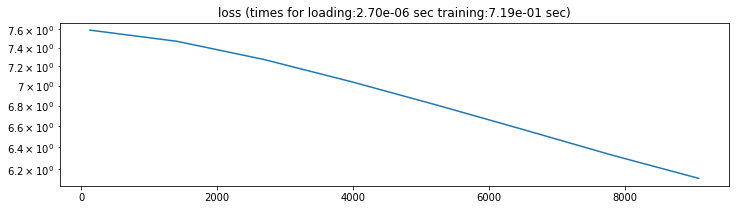

<Figure size 864x216 with 0 Axes>

In [6]:
trainer = helpers.Trainer(model)
trainer.set_lr(1e-6)
trainer.train_for(10000, training_dl)
clf()

# Training with Apex/AMP

In [7]:
from apex import amp

class AmpTrainer(helpers.Trainer):
    def __init__(self, model):
        super().__init__(model)
    def set_lr(self, lr, opt_level):
        optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
        self.model, self.optimizer = amp.initialize(
            self.model, optimizer, opt_level=opt_level,
            keep_batchnorm_fp32=True, loss_scale="dynamic")

- switch to FP16 by calling `amp.initialize` on the model and optimizer
- that's all!

# Performance Improvement

From 411 ms to 203 ms per batch (ResNet50, batch size 128).

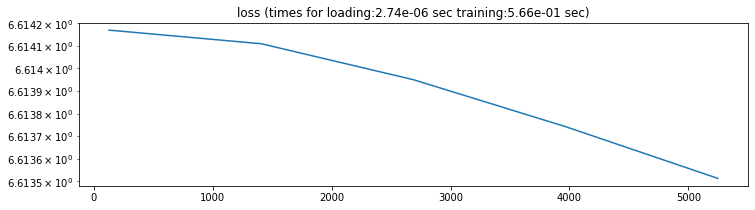

KeyboardInterrupt: 

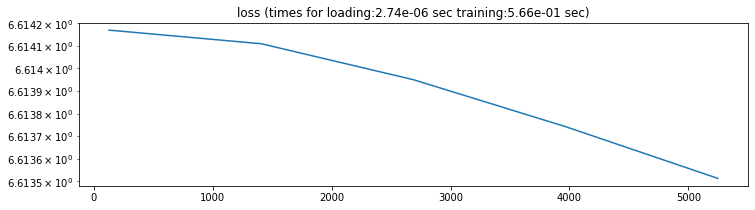

In [9]:
model = make_model().cuda()
amptrainer = AmpTrainer(model)
amptrainer.set_lr(1e-6, "O2")
amptrainer.train_for(10000, training_dl)
clf()

# APEX AMP FP16

- minimal changes to source code (just modify `Trainer` with a few lines)
- about a 2x speedup in this case